Author : 
Lauren Baillot
Merlin Boyer
Effie Segas

Projet Intelligence Artificielle 3A Robotique ENSEIRB/ENSC

Bibliothèques à importer pour le bon fonctionnement du projet

In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from ipywidgets import *
from IPython.display import *

Définition de la seed

In [55]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

Définition de la classe contenant le réseau

In [56]:
class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen
        self.file = open("text/Shakespeare.txt", "r").read()
        self.resSize = 300
        # taux de fuite alpha (desaprentissage)
        self.a = 0.3
        self.spectral_radius = 1.25
        self.input_scaling = 1.
        self.reg =  1e-8
        self.mode = 'prediction'
        seed = None #42
        set_seed(seed)

Initialisation du réseau

In [57]:
nw = Network()

2984429775
Seed used for random values: 2984429775


Traitement du texte

Prend le texte
Si keep_upper = True : respecte la casse,
sinon transforme le texte en minuscule.
Si keep_punctuation : garde la ponctuation,
sinon garde le texte sans la ponctuation.
Si keep_numbers : garde les chiffres,
sinon garde le texte sans chiffres.

In [58]:
def filter_characters(nw, keep_upper=True, keep_punctuation=True, keep_numbers=True) :

    alphabet = list("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ")
    numbers = list("0123456789")

    if keep_upper == False : nw.file = nw.file.lower()
    nw.input_text = list(nw.file)

    if keep_punctuation == False :
        nw.input_text = [i for i in nw.input_text if i in alphabet]     

    if keep_numbers == False :
        nw.input_text = [i for i in nw.input_text if i not in numbers]
    
    return(nw)

Création de deux dicos :
    input_units : clef sont les caractères et valeurs sont les positions
    outputs_units : clef sont les valeurs et valeurs sont les caractères
    

In [59]:
def characters(nw) :
    nw.input_units, nw.output_units = dict(), dict()
    for i, item in enumerate(set(nw.input_text)) :
        nw.input_units[item] = i
        nw.output_units[i] = item
    print("\nCaractères existants dans le texte :", sorted(nw.input_units),
          "\nNombre de caractères différents :", len(nw.input_units), "\n")
    return(nw)


Parcours input_text et pour chaque caractère regarde la valeur correspondante dans
input_units et ajoute dans data (remplace toutes les lettres par leur indices)
Crée la taille des couches entrées et sorties


In [79]:
def convert_input(nw) :
    nw.data = np.array([nw.input_units[i] for i in nw.input_text])
    nw.inSize = nw.outSize = len(nw.input_units)
    return(nw)

Fait des vecteurs binaires
data_b : autant de ligne que de caractères dans le texte et autant de colonnes que de caractères différents dans le texte
Puis met un 1 à l'indice correspondant au caractère.

In [80]:
def binary_data(nw) :
    nw.data_b = np.zeros((len(nw.input_text), len(nw.input_units)))
    for i, item in enumerate(nw.data) :
        nw.data_b[i][item] = 1
    return(nw)

Passage au code de ESN
1) initialise toutes les matrices

In [81]:
def initialization(nw) :
    #set_seed()
    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    nw.Ytarget = nw.data_b[nw.initLen+1:nw.trainLen+1].T
    nw.x = np.zeros((nw.resSize,1))
    return(nw)

2) Calcul du rayon spectrale ( maximum des valeurs propres de la matrice des poids du réservoir)
(fonction mettant à jour les poids)

In [63]:
def compute_spectral_radius(nw):
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    nw.W *= nw.spectral_radius / rhoW
    return(nw)

3) Entraine le réseau

In [64]:
def train_network(nw) :
    percent = 0.1
    for t in range(nw.trainLen):
        percent = progression(percent, t, nw.trainLen)
        nw.u = nw.data_b[t%len(nw.data)]
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.input_units)+1,1) ) + np.dot( nw.W, nw.x ) )
        if t >= nw.initLen :
            nw.X[:,t-nw.initLen] = np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.input_units)+nw.resSize+1,1)[:,0]      
    return(nw)

4) Met à jour les poids

In [65]:
def train_output(nw) :
    nw.X_T = nw.X.T
    if nw.reg is not None:
        nw.Wout = np.dot(np.dot(nw.Ytarget,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
    else:
        nw.Wout = np.dot(nw.Ytarget, linalg.pinv(nw.X) )   
    return(nw)

5) Test du network

In [66]:
def test(nw) :
    print('Testing the network... (', nw.mode, ' mode)', sep="", end=" ")
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data_b[nw.trainLen%len(nw.data)]
    percent = 0.1
    for t in range(nw.testLen):
        percent = progression(percent, t, nw.trainLen)
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.concatenate((np.array([1]),nw.u)).reshape(len(nw.input_units)+1,1)\
                                                   ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.concatenate((np.array([1]),nw.u,nw.x[:,0])).reshape(len(nw.input_units)+nw.resSize+1,1)[:,0] )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            # generative mode: se sert de la sortie précédente pour générer la suivante
            nw.u = nw.y
        elif nw.mode == 'prediction':
            # predictive mode: tente de prédire la sortie suivante
            nw.u = np.zeros(len(nw.input_units))
            nw.u[nw.data[(nw.trainLen+t+1)%len(nw.data)]] = 1
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")
    print('done.\n')
    return(nw)

6) Calcul de la meansquare error

In [67]:
def compute_error(nw) :
    print("Computing the error...", end=" ")
    errorLen = 500
    mse = sum( np.square( nw.data[(nw.trainLen+1)%len(nw.data):(nw.trainLen+errorLen+1)%len(nw.data)] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    return(nw)

Traduction de la sortie

In [68]:
def convert_output(nw) :
    nw.output_text = ""
    for i in range(len(nw.Y.T)) :
        nw.output_text += nw.output_units[nw.Y.T[i].argmax()]
    return(nw.output_text)

Calcul de la progression

In [69]:
def progression(percent, i, total) :
    if i == 0 :
        print("Progress :", end= " ")
        percent = 0.1
    elif (i/total) > percent :
        print(round(percent*100), end="")
        print("%", end=" ")
        percent += 0.1
    if total-i == 1 :
        print("100%")
    return(percent)

Applique toutes les fonctions sur le réseau

In [70]:
def compute_network(nw, a, b, c) :
    nw = filter_characters(nw, a, b, c)
    nw = characters(nw)
    nw = convert_input(nw)
    nw = binary_data(nw)
    nw = initialization(nw)
    nw = compute_spectral_radius(nw)
    nw = train_network(nw)
    nw = train_output(nw)
    nw = test(nw) 
    nw = compute_error(nw)
    nw = convert_output(nw)
    return(nw)

Configure network

In [82]:
select_mode = ToggleButtons(description='Mode:', options=['prediction', 'generative'])
text = Dropdown(description='Text:', options={"Shakespeare (4 573 338 chars.)" : 1, "Sherlock Holmes (3 868 223 chars)" : 2,
                                                   "Harry Potter and the Sorcerer's Stone (439 743 chars.)" : 3,
                                                   "Harry Potter and the Prisoner of Azkaban (611 584 chars.)" : 4}, value = 4)
var1 = Checkbox(description='Keep upper case letters?',value=True,)
var2 = Checkbox(description='Keep punctuation?',value=True,)
var3 = Checkbox(description='Keep numbers?',value=True,)
var4 = FloatSlider(value=300, min=0, max=5000, step=1, description='resSize')
var5 = FloatText(value=1000, description='initLen')
var6 = FloatText(value=10000, description='trainLen')
var7 = FloatText(value=2000, description='testLen')
var8 = FloatSlider(value=1.25, min=0, max=10, step=0.05, description='spectral radius')
var9 = FloatSlider(value=0.3, min=0, max=1, step=0.01, description='leak rate')
valid = Button(description='Validate')

def record_values(_):
    clear_output()
    nw.mode=select_mode.value
    file = text.value
    texts = ["Shakespeare.txt", "SherlockHolmes.txt", "HarryPotter1.txt", "HarryPotter3.txt"]
    nw.file = open("text/"+texts[file-1], "r").read()
    nw.resSize=int(var4.value)
    nw.initLen=int(var5.value)
    nw.trainLen=int(var6.value)
    nw.testLen=int(var7.value)
    nw.spectral_radius=float(var8.value)
    nw.a=float(var9.value)
    
    print("InitLen:", nw.initLen, "TrainLen:", nw.trainLen, "TestLen:", nw.testLen) 
    print("ResSize:", nw.resSize, "Spectral Radius:", nw.spectral_radius, "Leak Rate:", nw.a)
    
    compute_network(nw, var1.value, var2.value, var3.value)
    return(nw.output_text)

display(select_mode)
display(text)
display(var1)
display(var2)
display(var3)
display(var4)
display(var5)
display(var6)
display(var7)
display(var8)
display(var9)
display(valid)

output_text = valid.on_click(record_values)

ToggleButtons(description='Mode:', options=('prediction', 'generative'), value='prediction')

Dropdown(description='Text:', index=3, options={'Shakespeare (4 573 338 chars.)': 1, 'Sherlock Holmes (3 868 2…

Checkbox(value=True, description='Keep upper case letters?')

Checkbox(value=True, description='Keep punctuation?')

Checkbox(value=True, description='Keep numbers?')

FloatSlider(value=300.0, description='resSize', max=5000.0, step=1.0)

FloatText(value=1000.0, description='initLen')

FloatText(value=10000.0, description='trainLen')

FloatText(value=2000.0, description='testLen')

FloatSlider(value=1.25, description='spectral radius', max=10.0, step=0.05)

FloatSlider(value=0.3, description='leak rate', max=1.0, step=0.01)

Button(description='Validate', style=ButtonStyle())

Montrer le texte

In [76]:
valid3 = Button(description='Show the output!')

def show_output(_) :
    print(nw.output_text)

display(valid3)
valid3.on_click(show_output)

Button(description='Show the output!', style=ButtonStyle())

Affichage des caractères dans le texte

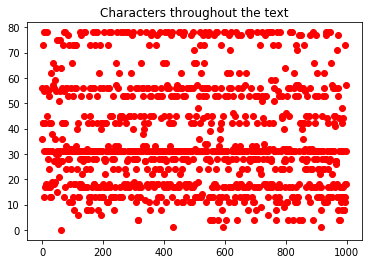

In [78]:
var10 = FloatText(value=1000, description='Number of chars')
valid2 = Button(description='Validate')
        
def trace_graph1(_) :
    clear_output()
    plt.figure(1).clear()
    limit = np.arange(int(var10.value))
    plt.plot(limit,nw.data[0:int(var10.value)], 'ro')
    plt.title('Characters throughout the text')
    
valid2.on_click(trace_graph1)
    
display(var10)
display(valid2)